# Variational AutoEncoder 

Variational AutoEncoder(이하 VAE)는 생성모델 중 하나이다. VAE는 GAN과 더불어 딥러닝 기반 생성모델로 널리 알려져 있으며, 2014년에 발표된 다음 두 논문에 기반한 방법이다.

* [Kingma and Welling, Auto-Encoding Variational Bayes, International Conference on Learning Representations (ICLR) 2014.](https://arxiv.org/abs/1312.6114)
* [Rezende, Mohamed and Wierstra, Stochastic Backpropagation and Approximate Inference
in Deep Generative Models. ICML 2014.](https://arxiv.org/abs/1401.4082)


여기서는 Kingma와 Welling이 ICLR 2014에 발표한 논문을 텐서플로우 2.0 기반으로 구현하여 VAE를 이해하도록 한다.

다음은 VAE에 대해 상세히 설명되어있는 참고 자료들이다.

* [PR-010: Auto-Encoding Variational Bayes, ICLR 2014, presented by Junbum Cha](https://youtu.be/KYA-GEhObIs)
* [오토인코더의 모든 것 - 1/3, by 이활석 (Naver D2 세미나)](https://youtu.be/o_peo6U7IRM)
* [Variational Autoencoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)
* [Conditional Variational Autoencoders, by Isaac Dykeman](http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
* [D.P. Kingma, Variational Inference and Deep Learning: A New Synthesis, Ph.D. Thesis](https://www.dropbox.com/s/v6ua3d9yt44vgb3/cover_and_thesis.pdf?dl=1)
* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)





## 생성 모델 문제

생성 모델 문제의 목표는 주어진 데이터셋과 유사하면서도 새로운 데이터를 생성해 낼 수 있는 모델을 수립하는 것이다. 확률적인 관점에서 본다면, 확률함수 $p^{*}(x)$를 구하는 문제이며, 해당 확률함수 $p^{*}$로 뽑힌 $x$는 우리가 가지고 있는 데이터셋과 유사해야 한다. 

$$ x \sim p^{*}(x)$$

그런데, 현실적으로 확률함수 $p^{*}(x)$를 알아내는 것은 불가능하다. 

예를 들어, 우리가 다루고자 하는 생성 모델 문제가 사람의 얼굴 영상을 만드는 문제라고 하자. 그럼 $p^{*}(x)$는 과거/현재/미래에 존재할 수 있는 모든 사람들의 얼굴을 만들어 낼 수 있는 확률함수이고, 해당 확률함수에서 뽑힌(drawn) $x$는 얼굴 영상이다.

### 딥러닝 기반 생성 모델
최근 딥러닝의 발전으로 생성 모델 문제를 데이터셋을 기반으로 한 딥뉴럴넷 학습으로 해결하려는 시도가 활발히 진행되고 있다. VAE와 GAN이 대표적인 예이다.

예를 들어, [CelebA 데이터셋](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)과 같이 유명인들의 얼굴을 찍어 놓은 영상들이  있다면, 이 데이터를 기반으로 한 생성 모델 문제는 새로운 얼굴 영상을 만들어 낼 수 있는 생성 모델 $p_{\theta}(x)$을 수립하는 것이다. 당연히, 우리가 수립하고자 하는 생성 모델은 미지의 진실 확률함수 $p^{*}(x)$를 최대한 잘 근사해야 할 것이다.

$$ p^{*}(x) \approx p_{\theta}(x)$$

이제 생성 모델 $p_{\theta}(x)$를 수립하는 문제를 다음과 같이 데이터 기반으로 한 학습과정으로 설명해 보자.

* 우리가 생성하려는 데이터의 총 집합을 $X$라 하자. 예를 들어 얼굴 생성 문제에서는 과거/현재/미래에 존재할 수 있는 모든 사람들의 얼굴을 찍은 영상 집합 $X$가 된다.
* 이제, 사람의 얼굴을 찍은 영상 $x$가 있다면, 이 영상은  총 집합 $X$로부터 어떤 확률적인 과정에 의해 뽑힌 것으로 생각하자. 즉, 
$$ x \sim p_{\theta}(x)$$
* 학습에 앞서, 생성 모델에 쓰일 확률함수 $p_{\theta}$의 구조를 정의한다. 즉, 딥뉴럴넷의 구조를 정의한다.
* 학습을 통해, 생성 모델에 쓰일 확률함수 $p_{\theta}$의 최적 파라메터 $\theta$를 학습한다. 즉, 딥뉴럴넷의 파라메터를 업데이트한다.

그런데,  $p_{\theta}(x)$도 역시 직접적으로 알아내는 것은 다루기 힘든(intractable) 문제이다. 하지만 다음과 같은 가정 하에 생성모델을 설계하고 훈련한다면, $p_{\theta}(x)$를 간접적으로 알아내는 것이 가능하다.


### 가정
생성 모델에서는 다음과 같이 데이터에 대해 의미있는 가정을 한다. 

* i.i.d 가정(independent and identical distribution assumption): 총 집합 $X$의 각 원소들을 $p_{\theta}(x)$에 의해 확률적으로 뽑는다면 각 시행은 독립적이며 동일한 분포를 가지게 된다.
* 충분한 양의 학습 데이터셋  $\{x^{(i)}\}_{i=1}^{N}$가 확보되어 있으면, 이 학습 데이터셋은 데이터의 모집합 $X$를 어느정도 대체할 수 있다.

즉, 각 데이터에 대해 동일 분포로부터 발생한 독립적인 사건의 곱으로 생각할 수 있다.

$$ p^{*}(X) \approx p_{\theta}(X) \approx p_{\theta}(\{x^{(i)}\}_{i=1}^{N}) = p_{\theta}(x^{(1)}, \cdots, x^{(N)}) = p_{\theta}(x^{(1)}) \cdots p_{\theta}(x^{(N)}) = \prod_{i=1}^{N}p_{\theta}(x^{(i)}) $$

로그 확률함수를 생각한다면, 다음과 같이 각 데이터의 로그 확률함수에 대한 합으로 생각할 수 있다.

$$\log p_{\theta}(x^{(1)}, \cdots, x^{(N)}) = \log p_{\theta}(x^{(1)}) + \cdots + \log p_{\theta}(x^{(N)}) = \sum_{i=1}^{N} \log p_{\theta}(x^{(i)})$$

얼굴 영상을 만드는 생성 문제에서 i.i.d 가정은 다음과 같이 해석될 수 있다. (independent) 생성 모델로 어떤 영상을 새롭게 만들었다면, 이는 이전에 생성된 혹은 그 이후에 생성될 영상에 영향을 주지 않는다. (identical) 뿐만 아니라 각 영상들은 얼굴에 관한 영상들이다. 즉, 얼굴 생성 모델이 자동차나 고양이 영상을 만들어 내지는 않는다.

## VAE 구조

구조적으로 봤을 때 VAE는 오토인코더와 거의 유사하다. 

![일반적인 오토인코더 구조](http://ijdykeman.github.io/assets/cvae_figures/ae_diagram.svg)


궁극적으로 오토인코더와 VAE가 다른 점은 latent space에 제한조건이 걸려있는지 여부이다. 

오토인코더는 동일한 훈련 데이터셋에 대해서도 훈련 초기조건에 따라 완전히 다른 latent space를 가지게 학습된다. 바로 이 점 때문에 오토인코더를 생성모델로서 활용할 수 없다. 반면, VAE는 인코더가 만들어내는 latent space를 우리가 원하는 확률모델과 유사한 모양을 가지도록 강제함으로써, 훈련된 VAE의 디코더 부분을 생성모델로 쓸 수 있다.

이러한 아이디어가 어떻게 VAE의 loss 수식에 반영되고, Tensorflow에서 VAE의 loss 수식이 어떻게 코딩에 반영되는지 살펴보도록 하자.




## VAE의 문제 정의

VAE는 생성 모델 문제를 다음과 같이 정의한다.


### Latent parameter $z$의 도입

우리가 찾고자 하는 $p_{\theta}(x)$를 직접 알아내는 것은 불가능하다.  하지만, 아마도 어떤 내제되어 있는 컨트롤 파라메터 $z$가 있어 $p_{\theta}(x)$를 간접적으로 접근할 수 있을 것이다. 즉,

$$ p_{\theta}(x) = \int p_{\theta}(x,z) dz $$

즉, $p_{\theta}(x)$를 곧바로 공략하지 않고, 1) joint probability $p_{\theta}(x, z)$를 알아낸 다음 2) 컨트롤 파라메터 $z$에 대해 적분하여 marginal probability $p_{\theta}(x)$를 알아내도록 하는 접근법을 생각하자.

이제 joint probability $p_{\theta}(x, z)$는 조건부 확률에 의해 다음과 같이 적을 수 있다.

$$ p_{\theta}(x, z) = p_{\theta}(x | z) p_{\theta}(z) $$


$p_{\theta}(x|z)$는 likelihood, $p_{\theta}(z)$는 prior라고 부르는데 그 의미는 다음과 같다.

* $p_{\theta}(z)$ 
  + 문제를 풀려고 하는 사람의 경험이 반영된 확률분포. 
  + 예를 들어, 우리가 풀고자 하는 문제에 컨트롤 가능한 $z$가 있을텐데, 이 $z$가 아마도 특정 확률분포 $p_{\theta}(z)$를 따를 것이라는 믿음. 
  + 알지도 못하는 **컨트롤 파라메터에 대한 확률적 믿음**이라는 의미에서 사건 $x$의 발생과 무관한 사전확률이라고 한다.
* $p_{\theta}(x|z)$
  + 주어진 컨트롤 파라메터 $z$가 있을 때, 데이터 $x$를 만들어 내는 확률분포. 
  + 주어진 latent parameter $z$가 기반하여 데이터 $x$를 추정한다는 의미에서 가능도(likelihood)라고 한다. 
  + 컨트롤 파라메터에 의해 데이터가 만들어지므로, **우리가 만들고자 하는 생성 모델**이 바로 이것이다.



### 컨트롤 가능한 Prior
Prior $p_{\theta}(z)$는 옳든 그르든 우리가 정하면 되는 확률이다. Prior $p_{\theta}(z)$를 컨트롤 가능한 확률분포로 설정하면 편리하기 때문에, VAE에서는 대부분 $p_{\theta}(z)$를 정규분포로 설정한다.

$$ p_{\theta}(z) \sim N(\mu, \sigma)$$

이제, prior $p_{\theta}(z)$를 정하는 문제는 정규분포의 $\mu$와 $\sigma$를 구하는 문제로 바뀌게 된다.


### 생성 모델에 해당하는 likelihood
컨트롤 파라메터 $z$가 주어졌을 때, 이로부터 데이터 $x$를 만드는 확률분포 $p_{\theta}(x | z)$를 알 수 있다면, 생성 문제는 다 해결한 것이다.

그런데, 조금만 생각해 보면 $p_{\theta}(x | z)$를 알아내는게 쉽지 않다는 것을 알 수 있다. 

얼굴 생성 문제로 다시 돌아가 보자. Prior $p_{\theta}(z)$는 앞서 우리가 임의로 정규분포로 가정했다. 즉, 정규분포를 따르는 확률변수 $z$를 하나 뽑은 것이다. 그 다음 뽑힌 $z$를 likelihood $p_{\theta}(x | z)$에 조건으로 주게 되면 얼굴 사진 $x$가 나와야 한다. 그럼, $p_{\theta}(x|z)$는 도대체 어떤 확률함수이길래 이런 마법같은 것을 할 수 있는 것일까?

VAE에서는 likelihood를 뉴럴넷으로 모델링 하고, 주어진 학습 데이터셋을 통해 이 뉴럴넷을 학습함으로써 likelihood $p_{\theta}(x|z)$를 구한다. 

$$ p_{\theta}(x|z) = \textrm{NeuralNet}(z)$$

이 때, 뉴럴넷 $\textrm{NeuralNet}(z)$의 출력은 영상이다. 만일 얼굴 데이터셋으로 뉴럴넷을 학습시켰다면, 뉴럴넷 $\textrm{NeuralNet}(z)$의 출력 $x$는 얼굴 영상이어야 한다.

## VAE의 문제 접근 방법

생성 모델에 해당하는 $p_{\theta}(x|z)$를 훈련시키는 모델을 구축하기 위해, 원래 문제 정의로 돌아가 보자.

원래 문제는 $p_{\theta}(x)$를 구하는 것이었다. $p_{\theta}(x)$를 직접 구하기 힘들기 때문에, 컨트롤 가능한 latent parameter $z$를 도입하여 $p_{\theta}(x,z)$ 문제를 푸는 걸로 접근법을 바꾸었다. 하지만 본질은 $p_{\theta}(x)$를 구하는 것이다.

어떤 방식으로 $p_{\theta}(x)$를 구하던지 간에 $p_{\theta}(x)$로 뽑은 $x$는 데이터셋에 있는 데이터들과 유사해야 한다. 즉, 얼굴 데이터셋을 가지고 생성모델을 만들었을 때, 해당 생성모델이 만든 $x$는 얼굴 영상 같이 보여야 한다는 뜻이다.

이러한 현상을 확률적으로 말하자면, $p_{\theta}(x)$가 최대화 되는 것이다.  같은 의미로 로그를 취한 형태인 $\log p_{\theta}(x)$ 역시 마찬가지로 최대화 되어야 한다.


### VAE의 핵심 수식

$\log p_{\theta}(x)$를 다음과 같이 우리가 도입한 컨트롤 가능한 latent parameter $z$와 결부시켜 보자.

$$ \log p_{\theta}(x) = \mathbb{E}_{z \sim q_{\phi}(z|x)} [ \log p_{\theta}(x) ] $$

즉, 컨트롤 파라메터 $z$를 랜덤하게 뽑아 이로부터 만들어낸 $\log p_{\theta}(x)$의 기대값은 최대가 되어야 한다. 식을 좀 더 정리하면, 다음과 같다.

$$
\begin{align} \log p_{\theta}(x) 
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} [ \log p_{\theta}(x) ] \\ 
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{p_{\theta}(z|x)} \right] \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \frac{q_{\phi}(z|x)}{p_{\theta}(z|x)} \right] \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \right] \right] 
  + \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{q_{\phi}(z|x)}{p_{\theta}(z|x)} \right] \right] \\
&= \mathcal{L}_{\theta,  \phi}(x) + D_{\textrm{KL}}(q_{\phi}(z|x)||p_{\theta}(z|x))
\end{align}
$$

수식 전개를 거쳐 마지막에 도출된 $\mathcal{L}_{\theta,  \phi}(x)$에 주목하도록 하자. $\mathcal{L}_{\theta,  \phi}(x)$을 Evidence Lower BOund (이하, ELBO)라 하는데, VAE의 loss를 결정하는 중요한 항이다. 

<!-- 조건부 확률에서 $p_{\theta}(x)$를 사건(evidence)라 부른다. 따라서, 우리의 목표는 $p(x)$를 최대화하는 것이다. 위 수식에는 evidence $p_{\theta}(x)$를 로그 형태 $\log p(x)$로 적었으므로, 우리의 목표는 로그 형태인 $\log p(x)$를 최대화하는 것이다.


* $\mathcal{L}(x)$: Evidence Lower BOund (이하, ELBO)라 불리는 항으로 인코더 네트웍이 만들어낸 latent variable $z$에 대한 확률분포와 해당 latent variable $z$를 이용해 만들어낸 디코더 네트웍의 출력물 사이의 연관성을 측정한다.
* $D_{\textrm{KL}}(q_{\phi}(z|x)||p_{\theta}(z|x))$: 인코더 네트웍이 만들어낸 latent variable $z$의 확률분포와 우리가 원했던 latent variable $z$의 확률분포 사이의 연관성을 측정한다.

 -->

### VAE 수식의 직관적 해석

조건부 확률에서 $p_{\theta}(x)$를 사건(evidence)라 부른다. 따라서, 우리의 목표는 $p_{\theta}(x)$를 최대화하는 것이다. 위 수식에는 evidence $p_{\theta}(x)$를 로그 형태 $\log p_{\theta}(x)$로 적었으므로, 우리의 목표는 로그 형태인 $\log p_{\theta}(x)$를 최대화하는 것이다.

앞서 살펴보았듯이, $\log p_{\theta}(x)$에 대한 수식 전개를 거쳐 결국 다음과 같이 ELBO과  KL의 합으로 도출되었다.

$$ \log p_{\theta}(x) = \mathcal{L}_{\theta,  \phi}(x) + D_{\textrm{KL}}(q_{\phi}(z|x)||p_{\theta}(z|x)) $$

그런데, KL 항은 두 확률분포의 차이, 즉 거리의 개념을 가지고 있기 때문에 항상 0보다 크다. 

따라서, $\log p_{\theta}(x)$을 최대화 하려면 ELBO 항을 최대로 만들어 자연스럽게 KL 항이 최소화 되도록 해야한다.


### ELBO 최대화
ELBO 수식은 다음과 같은 의미를 가진다. 

> $\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \right] \right]$: 인코더 네트웍이 만들어낸 latent variable $z$에 대한 확률분포  $q_{\phi}(z|x)$ 와 해당 latent variable $z$를 이용해 만들어낸 디코더 네트웍의 출력물  $p_{\theta}(x,z)=p_{\theta}(z)p_{\theta}(x|z)$ 사이의 연관성을 측정한다. 

ELBO를 최대화 한다는 의미는 인코더 $q_{\phi}$가 만들어낸 latent variable $z$로 만들어낼 결과물 $p_{\theta}(z)p_{\theta}(x|z)$, 즉 $p_{\theta}(x,z)$와는 관련이 없으면 없을수록 좋다. 당연히도, VAE에서 만들어내는 latent space는 VAE의 결과물과 달라야 하기 때문에 ELBO는 최대화(maximization) 해야하는 것이 말이 된다.

ELBO 수식을 전개하면 다음과 같다.


$$
\begin{align}
\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p(x,z)}{q_{\phi}(z|x)} \right] \right]
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x,z) - \log q_{\phi}(z|x) \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) + \log p_{\theta}(z) - \log q_{\phi}(z|x) \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log q_{\phi}(z|x) - \log p_{\theta}(z) \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[ \frac{q_{\phi}(z|x)}{p_{\theta}(z)} \right] \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - D_{\textrm{KL}}(q_{\phi}(z|x) || p_{\theta}(z)) \\
\end{align}
$$

ELBO를 최대화 하는 것은 다음의 두가지 의미를 갖는다.
* $\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right]$ 최대화: 이 항은 latent variable로 복구된 결과 $x$에 대한 기대값이다. 이 항을 다른 말로 **reconstruction term**이라 한다. ELBO가 최대화되려면 reconstruction term으로 복구된 결과의 기대값이 높아야 할 것이다. 
* $- D_{\textrm{KL}}(q_{\phi}(z|x) || \log p_{\theta}(z))$ 최대화: 이 항은 인코더 네트웍이 만들어낸 latent variable $z$의 확률분포와 우리가 원했던 latent variable $z$의 확률분포 사이의 연관성을 설명한다. 당연히 그 연관성이 높아야 하므로 $D_{\textrm{KL}}$은 최소로 되어야 하고, $-D_{\textrm{KL}}$는 최대화 되어야 할 것이다. 이 항을 다른 말로 **regularization term**이라 한다. 

### VAE loss 수식

VAE를 훈련할 때 쓰이는 loss 함수는 ELBO를 최대화 하는 방향이어야 한다. 일반적으로 loss는 최소화 되도록 설계되기 때문에, VAE의 loss는 다음과 같다.

$$ 
\begin{align}
\textrm{VAE loss} 
&= -\textrm{ELBO} \\
&= - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p(x|z) \right] + D_{\textrm{KL}}(q_{\phi}(z|x) || p_{\theta}(z)) \\
\end{align}
$$



<!-- ## 2.2 The variational bound
각 데이터 $x^{(i)}$에 대한 marginal likelihood는 다음과 같다.


$\log p_{\theta}(x^{(i)}) = D_{\textrm{KL}}(q_\phi(z|x^{(i)}) || p_{\theta}(z|x^{(i)})) + \mathcal{L}(\theta, \phi, x^{(i)})$

오른쪽 항에 2개의 텀이 있는데 
* 하나는 true posterior와 approximation의 차이를 재는 KL diverence이고,
* 다른 하나는 ELBO라 불리우는 evidence lower bound이다.

KL은 음수가 아니기 때문에 각 데이터의 marginal likelihood 와 ELBO는 다음의 상관관계를 가진다.

$$\log p_{\theta}(x^{(i)}) \geq \mathcal{L}(\theta, \phi, x^{(i)}) = \mathbb{E}_{q_{\phi}(z|x)}[-\log q_{\phi}(z|x) + \log p_{\theta}(x,z)]$$


ELBO에 관해서만 다시 수식을 정리하면,

$$\mathcal{L}(\theta, \phi, x^{(i)}) = -D_{\mathrm{KL}}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) + \mathbb{E}_{q_{\phi}(z|x^{(i)})}[\log p_{\theta}(x^{(i)}|z)]$$


주목해야할 것은 ELBO $\mathcal{L}(\theta, \phi, x^{(i)}) $이 variational parameter $\phi$와 generative parameter $\theta$에 모두 연관되어 있다는 것이다.  따라서, 두 파라메터에 대해 각각 미분가능함을 보이고 최적화하는 방식이 필요하다.  


그런데, variational parameter $\phi$에 대한 단순한 Monte Carlo gradient estimator는 다음과 같이

$$\nabla_\phi \mathbb{E}_{q_{\phi}(z)}[f(z)] = \mathbb{E}_{q_{\phi}(z)} [f(z) \nabla_{q_{\phi}(z)}\log q_\phi(z)]  \simeq \frac{1}{L} \sum_{l=1}^{L} f(z) \nabla_{q_{\phi}(z)} \log q_\phi(z)$$,
where 
$$ z^{(l)} \sim q_{\phi}(z|x^{(i)})$$

인데, [BJP12]에서 밝혀졌듯이 높은 분산을 가져 이 방식은 곤란한다.
 -->



In [0]:
x를 보고 만든 z의 분포 => encoder,
conditional auto encoder로 구현하려면 z,c를 넣어주면 된다.

## Reparameterization Trick

뉴럴넷을 recognition 모델로 쓸 경우, 본 논문에서 제안하는 내용이 variational auto-encoder가 된다.

Variational approximate posterior를 다음과 같이 multivariate Gaussian으로 잡도록 하자.

$$\log q_{\phi} (z | x^{(i)}) = \log\mathcal{N}(z; \mu^{(i)}, \sigma^{2(i)}\mathbf{I})$$


이제 다음의 ELBO 수식의 

$$\mathcal{L}(\theta, \phi, x^{(i)}) \simeq  -D_{\mathrm{KL}}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) + \mathbb{E}_{q_{\phi}(z|x^{(i)})}[\log p_{\theta}(x^{(i)}|z)]$$


우항 첫번째 term은 다음과 같이 쓸 수 있다. 
$$ -D_{\mathrm{KL}}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) = \frac{1}{2} \sum_{j=1}^{J} \left( 1 + \log((\sigma_{j}^{(i)})^2)) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \right) $$

여기서 $J$는 latent space의 dimension을 나타낸다.


우항 두번째 term은 Monte Carlo estimation으로 다음과 같이 쓸 수 있다. 
$$\mathbb{E}_{q_{\phi}(z|x^{(i)})}[\log p_{\theta}(x^{(i)}|z)] = \frac{1}{L}\sum_{l=1}^{L} \log p_{\theta}(x^{(i)}|z^{(i,l)})$$

여기서 $L$은 몬테카를로 샘플 개수를 나타낸다.



따라서, ELBO 수식은 다음과 같이 근사될 수 있다.
$$\mathcal{L}(\theta, \phi, x^{(i)}) \simeq  \frac{1}{2} \sum_{j=1}^{J} \left( 1 + \log((\sigma_{j}^{(i)})^2)) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \right) + \frac{1}{L}\sum_{l=1}^{L} \log p_{\theta}(x^{(i)}|z^{(i,l)})$$


### 원시적인 구현
텐서플로우 2.0 튜토리얼에 나와 있듯이, 위 수식을 그대로 구현하는 방법이 있다. 
* [Reparameterization Trick](https://www.tensorflow.org/alpha/tutorials/generative/cvae#reparameterization_trick)

인터넷에 있는 대부분의 VAE 구현 역시 reprameterization trick을 원시적인 구현한 코드들이다. 


### TensorFlow Probability
최근 Tensorflow 기능 중, 확률적인 함수의 parameter를 학습함에 있어 reparameterization trick과 같은 복잡한 과정없이 probability layer로써 학습이 가능한 기능들이 탑재되고 있다. TensorFlow Probability라는 기능이며, 자세한 사항은 다음 링크를 참고하도록 하자.

* [TensorFlow Probability](https://www.tensorflow.org/probability)

여기서는 VAE 구현 시, reparameterization trick을 쓰지 않고, 텐서플로우의 확률 레이어를 이용해 확률함수의 parameter를 추정하고자 한다.

# 참고문헌

TFP를 쓰려면 Tensorflow 2.0 nightly build를 설치해야 함

* [Probabilistic Layers VAE](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb#scrollTo=eRHjRtAL-e33)
* [Variational Inference in TensorFlow](https://danijar.com/materials/variational-inference-in-tensorflow.pdf)
* [PyMC3](https://docs.pymc.io/)

In [0]:
!pip install -q --upgrade tf-nightly-gpu-2.0-preview
!pip install -q tfp-nightly

In [0]:
import tensorflow as tf                       # 텐서플로우 임포트
import tensorflow_probability as tfp


from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np

print("Tensorflow: ", tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print("Keras: ", tf.keras.__version__)  # 케라스 버전을 확인한다.

print("Tensorflow Probability: ", tfp.__version__)       # TFP 버젼을 확인한다.


Tensorflow:  2.0.0-dev20190620
Keras:  2.2.4-tf
Tensorflow Probability:  0.8.0-dev20190620


In [0]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalizing the images to the range of [0., 1.]
train_images = train_images / 255.0
test_images = test_images / 255.0

# # binarization
# train_images[train_images >= 0.5] = 1.0
# train_images[train_images <  0.5] = 0.0
# test_images[test_images >= 0.5] = 1.0
# test_images[test_images <  0.5] = 0.0

# tensorflow probablity layer가 float32를 입력을 받기 때문에 float64를 float32로 캐스팅
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

print(train_images.shape)
print(test_images.shape)
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels[0].dtype)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(28, 28)
float32
uint8


### MNIST 데이터의 label인 10차원 벡터를 condition으로 추가한다.

In [0]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)

# 데이터 변환 확인
print(train_label_onehots.shape)
print(test_label_onehots.shape)

print(train_label_onehots[0])
print(train_labels[0])
print(test_label_onehots[0])
print(test_labels[0])

(60000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


###encoder가 출력하는 z의 차원을 초기에 2로 가정하고 테스트한다.

In [0]:
tfd = tfp.distributions

enc_dim = 2

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

Sequential로 구성된 encoder에 condition을 추가해야 한다. 따라서  concatenate함수로 처리하기 위해 encoder를 재구성한다.


In [0]:
img = tf.keras.Input(shape=(28,28))
con = tf.keras.Input(shape=(10,))

enc_dense_1 = tf.keras.layers.Dense(256, activation='relu')
enc_dense_2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense_3 = tf.keras.layers.Dense( 64, activation='relu')
enc_dense_4 = tf.keras.layers.Dense(enc_dim + enc_dim)
enc_dense_5 = tfp.layers.IndependentNormal(enc_dim, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1))
enc_dense_6 = tf.keras.layers.Dense(enc_dim)

flat_img = tf.keras.layers.Flatten()(img)
x = tf.keras.layers.concatenate([flat_img, con])
x = enc_dense_1(x)
x = enc_dense_2(x)
x = enc_dense_3(x)
x = enc_dense_4(x)
x = enc_dense_5(x)
z = enc_dense_6(x)

encoder = models.Model([img, con], z)

마찬가지로, Sequential로 구성된 decoder를 concatenate함수로 처리하기 위해 decoder를 재구성한다.

In [0]:
dec_dense_1 = tf.keras.layers.Dense( 64, activation='relu')
dec_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4 = tf.keras.layers.Dense(784, activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))

x = tf.keras.layers.concatenate([z, con])
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

In [0]:
z_sample = layers.Input(shape=(enc_dim,))

## conditional generative model
z_cond = layers.concatenate([z_sample, con])
x_dec = dec_dense_1(z_cond)
x_dec = dec_dense_2(x_dec)
x_dec = dec_dense_3(x_dec)
x_dec = dec_dense_4(x_dec)
y_dec_pred = dec_reshape(x_dec)

decoder = models.Model([z_sample, con], y_dec_pred)

위에서 구현한 모델들을 통해 Conditional VAE model을 구축한다.

In [0]:
vae = tf.keras.Model(inputs=[img, con], outputs=y_pred)

## 훈련 전, 네트워크 모델을 함수로서 활용



*   훈련 전 네트워크이기 때문에 정상적으로 작동하지 않는다.






In [0]:
results = vae([train_images, train_label_onehots])

print('input shape:', train_images.shape)
print('output shape:', results.shape)

input shape: (60000, 28, 28)
output shape: (60000, 28, 28)


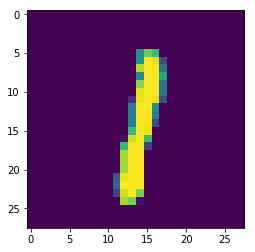

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt

img_in  = train_images[1200]
plt.imshow(img_in)

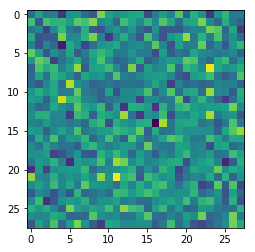

In [0]:
img_out  = results[1200]
plt.imshow(img_out)

학습되지 않은 모델이기 때문에, 엉뚱한 결과를 출력한다.

## Conditional VAE의 텐서 구조

In [0]:
# VAE 모델 컴파일 (* loss 함수가 중요!)

vae.compile(optimizer='adam',            
            loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM),
            metrics=['mae'])

Conditional VAE의 전체적인 구조는 다음과 같다.

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 794)          0           flatten_3[0][0]                  
                                                                 input_9[0][0]             

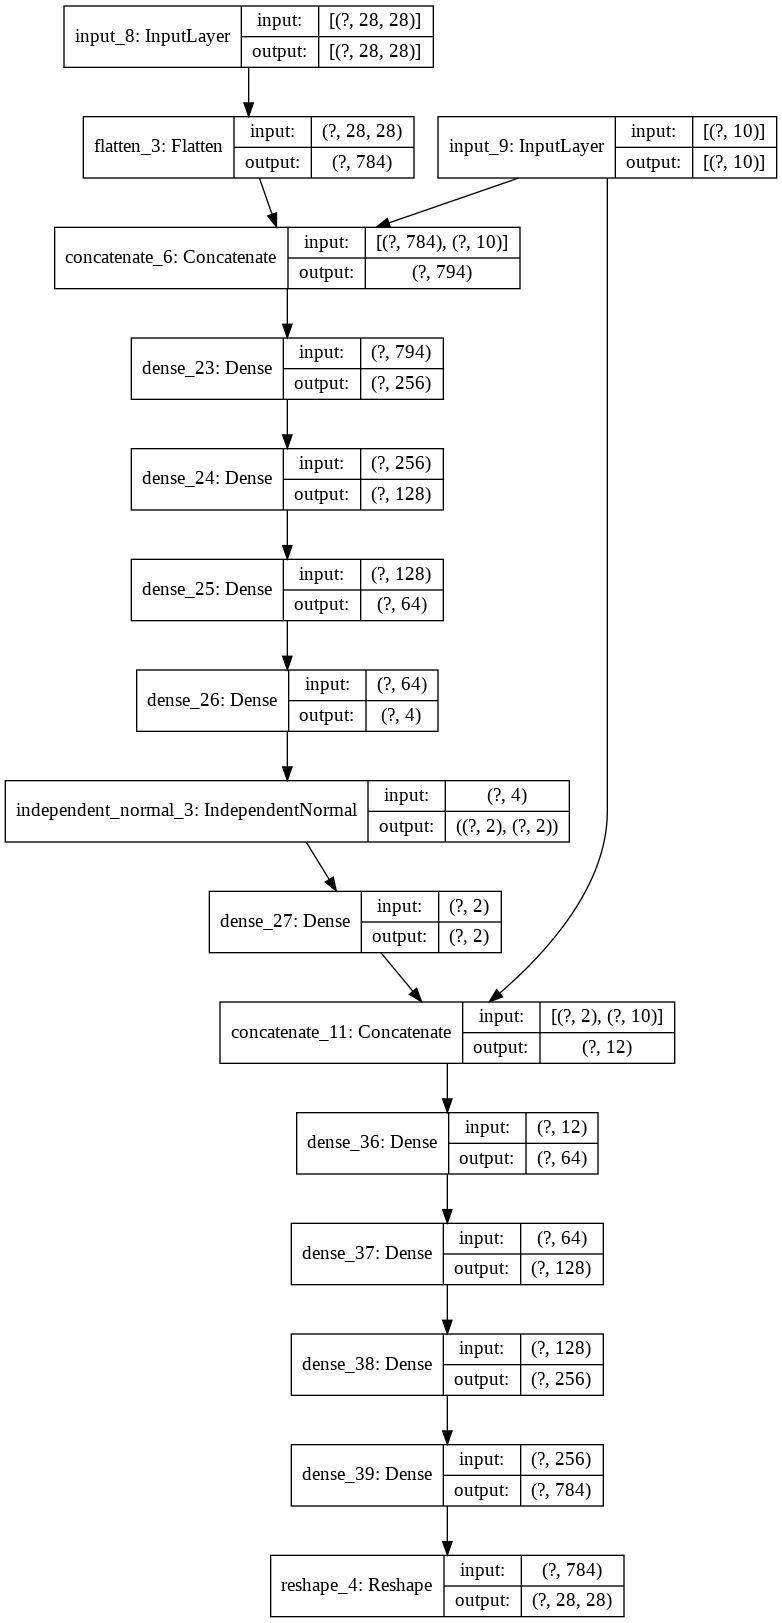

In [0]:
vae.summary()
tf.keras.utils.plot_model(vae, 'vae_model.png', show_shapes=True)

*   위의 이미지를 통해서, Conditional VAE의 인코더에는 이미지와 condition이 추가된 형태의 텐서가 입력으로 들어오게 된다. 초기이미지의 텐서 구조는 (?, 28, 28)으로, 28x28 형태의 사진이 랜덤하게 들어온다는 의미이다. 여기에서, 28x28의 이차원 텐서 구조의 이미지를 Flatten함수를 통해 1차원으로 만들었기 때문에 (?, 784)가 된다. 여기에서 condition의 텐서 구조는 (?, 10)이다. 역시나 이미지가 랜덤하게 들어오기 때문에 ?로 표현된다. flatten된 이미지의 텐서에 concatenate 함수를 통해서 condition과 결합하였기 때문에 Conditional VAE의 encoder에 입력으로 주어야 하는 텐서 구조는 (?, 794)가 된다.
*   Conditional VAE의 디코더에는 encoder를 통해 출력되는 z의 차원을 2로 설정하였기 때문에 z와 condition을 concatenate 함수를 통해  결합한 (?, 12)의 텐서 구조가 입력으로 들어오게 된다.





Encoder 부분의 구조는 다음과 같다. 

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 794)          0           flatten_3[0][0]                  
                                                                 input_9[0][0]              

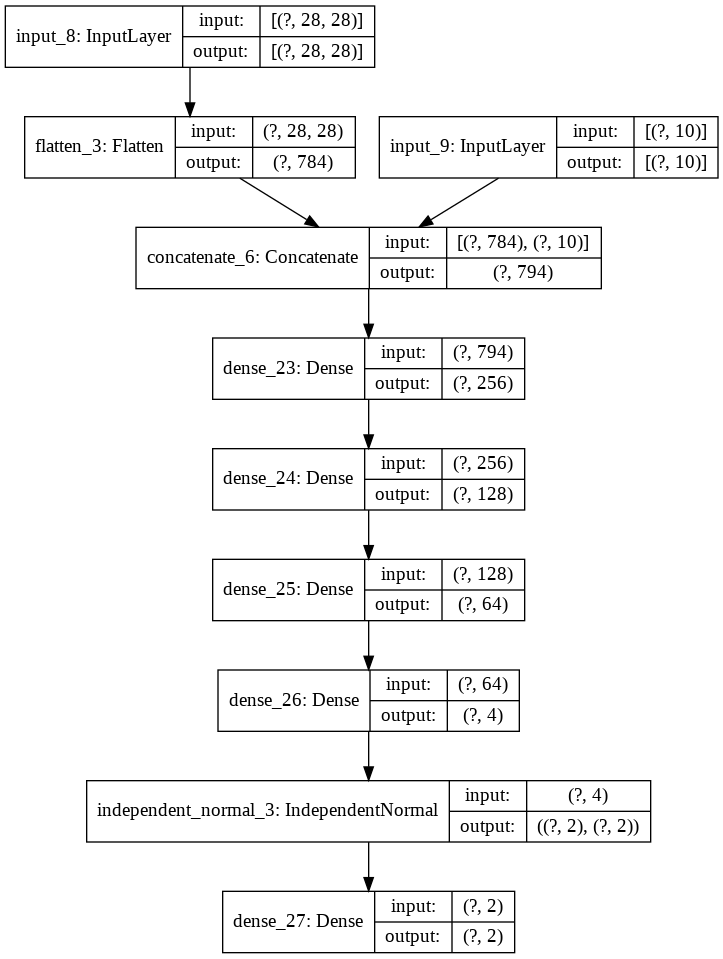

In [0]:
encoder.summary()
tf.keras.utils.plot_model(encoder, 'encoder_model.png', show_shapes=True)

decoder 부분의 구조는 다음과 같다.

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 12)           0           input_11[0][0]                   
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 64)           832         concatenate_10[0][0]       

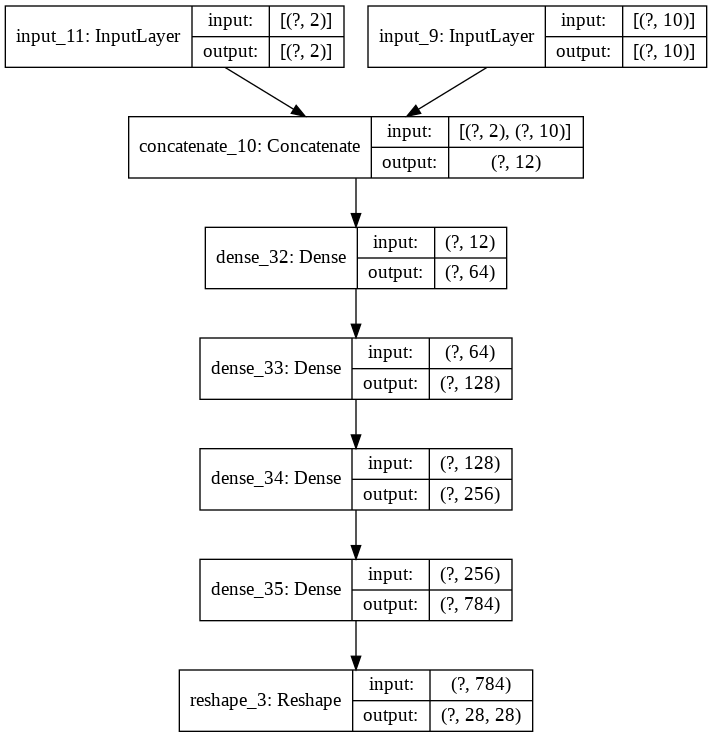

In [0]:
decoder.summary()
tf.keras.utils.plot_model(decoder, 'decoder_model.png', show_shapes=True)

## Conditional VAE 인스턴스 트레이닝

epoch를 20, batch size를 100으로 설정하여 Conditional VAE를 학습시킨다.

In [0]:
epochs = 20
batch_size = 100

vae.fit([train_images, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 50us/sample - loss: 612.7490 - mae: 0.1197
Epoch 2/20
60000/60000 [==============================] - 3s 45us/sample - loss: 498.8619 - mae: 0.0912
Epoch 3/20
60000/60000 [==============================] - 3s 45us/sample - loss: 481.2798 - mae: 0.0865
Epoch 4/20
60000/60000 [==============================] - 3s 46us/sample - loss: 473.5247 - mae: 0.0844
Epoch 5/20
60000/60000 [==============================] - 3s 46us/sample - loss: 469.1371 - mae: 0.0832
Epoch 6/20
60000/60000 [==============================] - 3s 47us/sample - loss: 465.8750 - mae: 0.0823
Epoch 7/20
60000/60000 [==============================] - 3s 46us/sample - loss: 463.4809 - mae: 0.0817
Epoch 8/20
60000/60000 [==============================] - 3s 47us/sample - loss: 461.4928 - mae: 0.0812
Epoch 9/20
60000/60000 [==============================] - 3s 46us/sample - loss: 459.8657 - mae: 0.0807
Epoch 10/20
60000/60000 [================

## 트레이닝이 끝난 Conditional VAE 이용하기
트레이닝이 끝난 VAE는 함수의 형태로 작동이 가능하다.

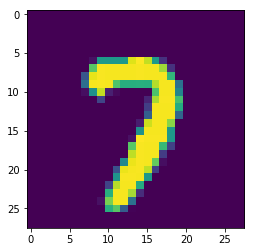

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt

img_in  = train_images[1300]
plt.imshow(img_in)

In [0]:
results = vae([train_images, train_label_onehots])

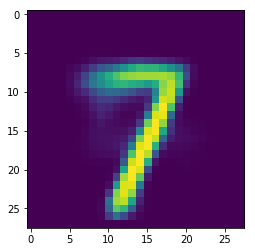

In [0]:
img_out = results[1300]
plt.imshow(img_out)

훈련이 정상적으로 되어 입력에 대해 올바른 결과를 출력하는 것을 확인할 수 있다.

# 디코더 부분을 따로 모델로 설정하기
다음과 같은 방법으로 트레이닝이 끝난 Conditional VAE의 디코더를 모델로서 활용할 수  있다.

In [0]:
## input layer (special purposes for conditional generative model)
z_sample = layers.Input(shape=(enc_dim,))


## conditional generative model
z_cond = layers.concatenate([z_sample, con])
x_dec = dec_dense_1(z_cond)
x_dec = dec_dense_2(x_dec)
x_dec = dec_dense_3(x_dec)
x_dec = dec_dense_4(x_dec)
y_dec_pred = dec_reshape(x_dec)

cond_decoder = models.Model([z_sample, con], y_dec_pred)

# 디코더를 이용한 Generative Model 구성
conditional label에 따라 해당 label에 대응하는 데이터가 출력되는 것을 확인할 수 있다.

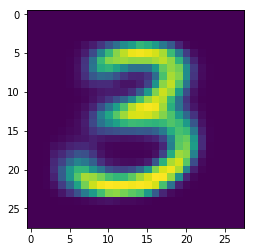

In [0]:
zzz = np.array([[0.0, 0.0]]) # 2차원 벡터의 다발 

l0 = 0  #@param {type: "slider", min: 0, max: 1}
l1 = 0  #@param {type: "slider", min: 0, max: 1}
l2 = 0  #@param {type: "slider", min: 0, max: 1}
l3 = 1  #@param {type: "slider", min: 0, max: 1}
l4 = 0  #@param {type: "slider", min: 0, max: 1}
l5 = 0  #@param {type: "slider", min: 0, max: 1}
l6 = 0  #@param {type: "slider", min: 0, max: 1}
l7 = 0  #@param {type: "slider", min: 0, max: 1}
l8 = 0  #@param {type: "slider", min: 0, max: 1}
l9 = 0  #@param {type: "slider", min: 0, max: 1}

ccc = np.array([[l0, l1, l2, l3, l4, l5, l6, l7, l8, l9]]) # 표현하고자 하는 conditional label을 1로 표시한다.
                # 0    1    2    3    4    5    6    7    8    9

zzz = zzz.astype('float32')
ccc = ccc.astype('float32')

rrr = cond_decoder([zzz , ccc])

# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt

img_out = rrr[0]
plt.imshow(img_out)

# 인코딩 결과 가시화 (각 라벨별로 분류)
Conditional VAE가 만들어 내는 representation인 z값을 라벨별로 분류하여 가시화한다.

(5923, 10)
(6742, 10)
(5958, 10)
(6131, 10)
(5842, 10)
(5421, 10)
(5918, 10)
(6265, 10)
(5851, 10)
(5949, 10)


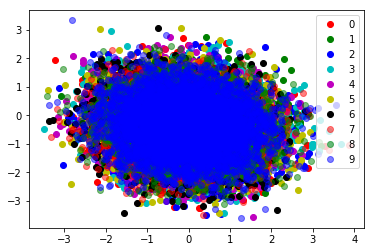

In [0]:
cond_z = encoder([train_images, train_label_onehots])

z_0 = cond_z[train_labels==0]
z_1 = cond_z[train_labels==1]
z_2 = cond_z[train_labels==2]
z_3 = cond_z[train_labels==3]
z_4 = cond_z[train_labels==4]
z_5 = cond_z[train_labels==5]
z_6 = cond_z[train_labels==6]
z_7 = cond_z[train_labels==7]
z_8 = cond_z[train_labels==8]
z_9 = cond_z[train_labels==9]

## 각 라벨별 데이터의 갯수 
print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_3.shape)
print(z_4.shape)
print(z_5.shape)
print(z_6.shape)
print(z_7.shape)
print(z_8.shape)
print(z_9.shape)

plt.plot(z_0[:,0], z_0[:,1], 'ro', label='0')
plt.plot(z_1[:,0], z_1[:,1], 'go', label='1')
plt.plot(z_2[:,0], z_2[:,1], 'bo', label='2')
plt.plot(z_3[:,0], z_3[:,1], 'co', label='3')
plt.plot(z_4[:,0], z_4[:,1], 'mo', label='4')
plt.plot(z_5[:,0], z_5[:,1], 'yo', label='5')
plt.plot(z_6[:,0], z_6[:,1], 'ko', label='6')
plt.plot(z_7[:,0], z_7[:,1], 'ro', alpha=0.5, label='7')
plt.plot(z_8[:,0], z_8[:,1], 'go', alpha=0.5, label='8')
plt.plot(z_9[:,0], z_9[:,1], 'bo', alpha=0.5, label='9')

plt.legend()

### MNIST 데이터셋의 representation p(z)를 라벨별로 분리하여 가시화하면 다음과 같다.


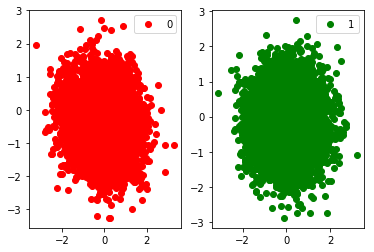

In [0]:
plt.subplot(121)
plt.plot(z_0[:,0], z_0[:,1], 'ro', label='0')
plt.legend()

plt.subplot(122)
plt.plot(z_1[:,0], z_1[:,1], 'go', label='1')
plt.legend()

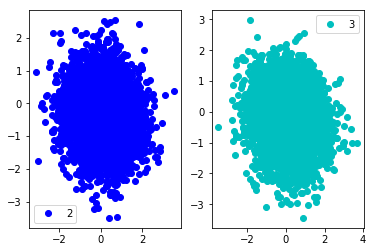

In [0]:
plt.subplot(121)
plt.plot(z_2[:,0], z_2[:,1], 'bo', label='2')
plt.legend()

plt.subplot(122)
plt.plot(z_3[:,0], z_3[:,1], 'co', label='3')
plt.legend()

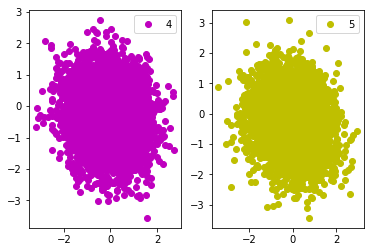

In [0]:
plt.subplot(121)
plt.plot(z_4[:,0], z_4[:,1], 'mo', label='4')
plt.legend()

plt.subplot(122)
plt.plot(z_5[:,0], z_5[:,1], 'yo', label='5')
plt.legend()

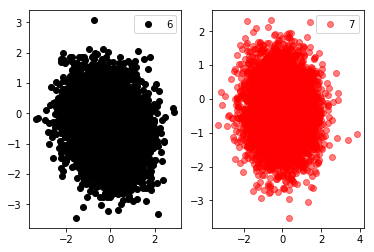

In [0]:
plt.subplot(121)
plt.plot(z_6[:,0], z_6[:,1], 'ko', label='6')
plt.legend()

plt.subplot(122)
plt.plot(z_7[:,0], z_7[:,1], 'ro', alpha=0.5, label='7')
plt.legend()

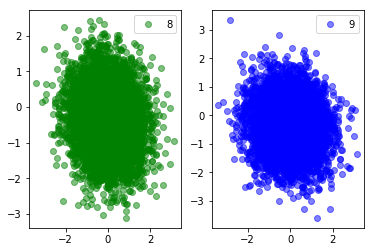

In [0]:
plt.subplot(121)
plt.plot(z_8[:,0], z_8[:,1], 'go', alpha=0.5, label='8')
plt.legend()

plt.subplot(122)
plt.plot(z_9[:,0], z_9[:,1], 'bo', alpha=0.5, label='9')
plt.legend()

라벨별로 데이터의 분포를 확인한 결과, (0,0)을 중심으로 널리 퍼져 분포하고 있는 것을 볼 수 있다. 따라서, representation p(z)는 normal distribution을 따른다고 할 수 있다.

## z의 차원을 바꿔서 실험해본다.
z의 차원을 10으로 설정하고, encoder과 decoder를 구현한다.

In [0]:
enc_dim = 10

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

img = tf.keras.Input(shape=(28,28))
con = tf.keras.Input(shape=(10,))

enc_dense_1 = tf.keras.layers.Dense(256, activation='relu')
enc_dense_2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense_3 = tf.keras.layers.Dense( 64, activation='relu')
enc_dense_4 = tf.keras.layers.Dense(enc_dim + enc_dim)
enc_dense_5 = tfp.layers.IndependentNormal(enc_dim, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1))
enc_dense_6 = tf.keras.layers.Dense(enc_dim)

flat_img = tf.keras.layers.Flatten()(img)
x = tf.keras.layers.concatenate([flat_img, con])
x = enc_dense_1(x)
x = enc_dense_2(x)
x = enc_dense_3(x)
x = enc_dense_4(x)
x = enc_dense_5(x)
z = enc_dense_6(x)

encoder = models.Model([img, con], z)

dec_dense_1 = tf.keras.layers.Dense( 64, activation='relu')
dec_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4 = tf.keras.layers.Dense(784, activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))

x = tf.keras.layers.concatenate([z, con])
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

z_sample = layers.Input(shape=(enc_dim,))

## conditional generative model
z_cond = layers.concatenate([z_sample, con])
x_dec = dec_dense_1(z_cond)
x_dec = dec_dense_2(x_dec)
x_dec = dec_dense_3(x_dec)
x_dec = dec_dense_4(x_dec)
y_dec_pred = dec_reshape(x_dec)

decoder = models.Model([z_sample, con], y_dec_pred)

# VAE 모델 컴파일

vae.compile(optimizer='adam',            
            loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM),
            metrics=['mae'])

해당 conditional VAE 모델을 학습시킨다.

In [0]:
epochs = 20
batch_size = 100

vae.fit([train_images, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 47us/sample - loss: 427.6755 - mae: 0.0755
Epoch 2/20
60000/60000 [==============================] - 3s 44us/sample - loss: 427.2693 - mae: 0.0754
Epoch 3/20
60000/60000 [==============================] - 3s 44us/sample - loss: 426.6191 - mae: 0.0753
Epoch 4/20
60000/60000 [==============================] - 3s 44us/sample - loss: 426.2588 - mae: 0.0751
Epoch 5/20
60000/60000 [==============================] - 3s 45us/sample - loss: 426.0179 - mae: 0.0751
Epoch 6/20
60000/60000 [==============================] - 3s 44us/sample - loss: 425.4082 - mae: 0.0749
Epoch 7/20
60000/60000 [==============================] - 3s 44us/sample - loss: 425.9110 - mae: 0.0750
Epoch 8/20
60000/60000 [==============================] - 3s 44us/sample - loss: 426.2585 - mae: 0.0751
Epoch 9/20
60000/60000 [==============================] - 3s 44us/sample - loss: 426.4719 - mae: 0.0752
Epoch 10/20
60000/60000 [================

(5923, 10)
(6742, 10)
(5958, 10)
(6131, 10)
(5842, 10)
(5421, 10)
(5918, 10)
(6265, 10)
(5851, 10)
(5949, 10)


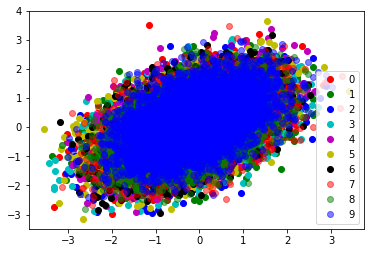

In [0]:
cond_z = encoder([train_images, train_label_onehots])

z_0 = cond_z[train_labels==0]
z_1 = cond_z[train_labels==1]
z_2 = cond_z[train_labels==2]
z_3 = cond_z[train_labels==3]
z_4 = cond_z[train_labels==4]
z_5 = cond_z[train_labels==5]
z_6 = cond_z[train_labels==6]
z_7 = cond_z[train_labels==7]
z_8 = cond_z[train_labels==8]
z_9 = cond_z[train_labels==9]

## 각 라벨별 데이터의 갯수 
print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_3.shape)
print(z_4.shape)
print(z_5.shape)
print(z_6.shape)
print(z_7.shape)
print(z_8.shape)
print(z_9.shape)

plt.plot(z_0[:,0], z_0[:,1], 'ro', label='0')
plt.plot(z_1[:,0], z_1[:,1], 'go', label='1')
plt.plot(z_2[:,0], z_2[:,1], 'bo', label='2')
plt.plot(z_3[:,0], z_3[:,1], 'co', label='3')
plt.plot(z_4[:,0], z_4[:,1], 'mo', label='4')
plt.plot(z_5[:,0], z_5[:,1], 'yo', label='5')
plt.plot(z_6[:,0], z_6[:,1], 'ko', label='6')
plt.plot(z_7[:,0], z_7[:,1], 'ro', alpha=0.5, label='7')
plt.plot(z_8[:,0], z_8[:,1], 'go', alpha=0.5, label='8')
plt.plot(z_9[:,0], z_9[:,1], 'bo', alpha=0.5, label='9')

plt.legend()

z의 차원을 100으로 설정하고, encoder과 decoder를 구현한다.

In [0]:
enc_dim = 100

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

img = tf.keras.Input(shape=(28,28))
con = tf.keras.Input(shape=(10,))

enc_dense_1 = tf.keras.layers.Dense(256, activation='relu')
enc_dense_2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense_3 = tf.keras.layers.Dense( 64, activation='relu')
enc_dense_4 = tf.keras.layers.Dense(enc_dim + enc_dim)
enc_dense_5 = tfp.layers.IndependentNormal(enc_dim, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1))
enc_dense_6 = tf.keras.layers.Dense(enc_dim)

flat_img = tf.keras.layers.Flatten()(img)
x = tf.keras.layers.concatenate([flat_img, con])
x = enc_dense_1(x)
x = enc_dense_2(x)
x = enc_dense_3(x)
x = enc_dense_4(x)
x = enc_dense_5(x)
z = enc_dense_6(x)

encoder = models.Model([img, con], z)

dec_dense_1 = tf.keras.layers.Dense( 64, activation='relu')
dec_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4 = tf.keras.layers.Dense(784, activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))

x = tf.keras.layers.concatenate([z, con])
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

z_sample = layers.Input(shape=(enc_dim,))

## conditional generative model
z_cond = layers.concatenate([z_sample, con])
x_dec = dec_dense_1(z_cond)
x_dec = dec_dense_2(x_dec)
x_dec = dec_dense_3(x_dec)
x_dec = dec_dense_4(x_dec)
y_dec_pred = dec_reshape(x_dec)

decoder = models.Model([z_sample, con], y_dec_pred)

# VAE 모델 컴파일

vae.compile(optimizer='adam',            
            loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM),
            metrics=['mae'])

In [0]:
epochs = 20
batch_size = 100

vae.fit([train_images, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 46us/sample - loss: 423.1462 - mae: 0.0744
Epoch 2/20
60000/60000 [==============================] - 3s 42us/sample - loss: 423.2228 - mae: 0.0744
Epoch 3/20
60000/60000 [==============================] - 3s 42us/sample - loss: 422.8161 - mae: 0.0743
Epoch 4/20
60000/60000 [==============================] - 3s 42us/sample - loss: 423.3841 - mae: 0.0744
Epoch 5/20
60000/60000 [==============================] - 3s 42us/sample - loss: 424.4905 - mae: 0.0747
Epoch 6/20
60000/60000 [==============================] - 2s 41us/sample - loss: 423.6804 - mae: 0.0745
Epoch 7/20
60000/60000 [==============================] - 2s 42us/sample - loss: 422.7922 - mae: 0.0743
Epoch 8/20
60000/60000 [==============================] - 3s 42us/sample - loss: 422.0648 - mae: 0.0741
Epoch 9/20
60000/60000 [==============================] - 3s 43us/sample - loss: 423.3672 - mae: 0.0744
Epoch 10/20
60000/60000 [================

(5923, 100)
(6742, 100)
(5958, 100)
(6131, 100)
(5842, 100)
(5421, 100)
(5918, 100)
(6265, 100)
(5851, 100)
(5949, 100)


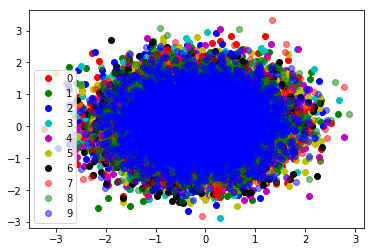

In [0]:
cond_z = encoder([train_images, train_label_onehots])

z_0 = cond_z[train_labels==0]
z_1 = cond_z[train_labels==1]
z_2 = cond_z[train_labels==2]
z_3 = cond_z[train_labels==3]
z_4 = cond_z[train_labels==4]
z_5 = cond_z[train_labels==5]
z_6 = cond_z[train_labels==6]
z_7 = cond_z[train_labels==7]
z_8 = cond_z[train_labels==8]
z_9 = cond_z[train_labels==9]

## 각 라벨별 데이터의 갯수 
print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_3.shape)
print(z_4.shape)
print(z_5.shape)
print(z_6.shape)
print(z_7.shape)
print(z_8.shape)
print(z_9.shape)

plt.plot(z_0[:,0], z_0[:,1], 'ro', label='0')
plt.plot(z_1[:,0], z_1[:,1], 'go', label='1')
plt.plot(z_2[:,0], z_2[:,1], 'bo', label='2')
plt.plot(z_3[:,0], z_3[:,1], 'co', label='3')
plt.plot(z_4[:,0], z_4[:,1], 'mo', label='4')
plt.plot(z_5[:,0], z_5[:,1], 'yo', label='5')
plt.plot(z_6[:,0], z_6[:,1], 'ko', label='6')
plt.plot(z_7[:,0], z_7[:,1], 'ro', alpha=0.5, label='7')
plt.plot(z_8[:,0], z_8[:,1], 'go', alpha=0.5, label='8')
plt.plot(z_9[:,0], z_9[:,1], 'bo', alpha=0.5, label='9')

plt.legend()

z의 차원을 다양하게 하여 실험한 결과, z의 차원을 늘릴 때마다 타원 모양의 분포 형태가 위쪽 방향으로 기울면서 조금씩 달라지는 것을 확인할 수 있다.

### p(z)에서 샘플링한 z 값을 decoder으로 주었을 때 손글씨 숫자 이미지가 만들어지는지 확인한다.

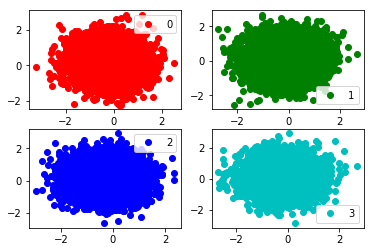

In [0]:
plt.subplot(221)
plt.plot(z_0[:,0], z_0[:,1], 'ro', label='0')
plt.legend()

plt.subplot(222)
plt.plot(z_1[:,0], z_1[:,1], 'go', label='1')
plt.legend()

plt.subplot(223)
plt.plot(z_2[:,0], z_2[:,1], 'bo', label='2')
plt.legend()

plt.subplot(224)
plt.plot(z_3[:,0], z_3[:,1], 'co', label='3')
plt.legend()

라벨별 z의 분포의 중심점은 모두 normal distribution을 따르기 때문에 (0, 0)이다. 따라서 z의 값은 모두 (0, 0)으로 주고, condition만 각각 다르게 준 다음 decoder를 통해 어떤 이미지가 생성되는지 확인해보도록 한다.

In [0]:
z = np.array([[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]])

con = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
                [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 
                [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

result = decoder.predict([z, con])

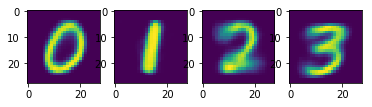

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt

plt.subplot(141)
plt.imshow(result[0])
plt.subplot(142)
plt.imshow(result[1])
plt.subplot(143)
plt.imshow(result[2])
plt.subplot(144)
plt.imshow(result[3])

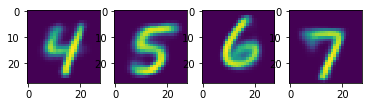

In [0]:
plt.subplot(141)
plt.imshow(result[4])
plt.subplot(142)
plt.imshow(result[5])
plt.subplot(143)
plt.imshow(result[6])
plt.subplot(144)
plt.imshow(result[7])

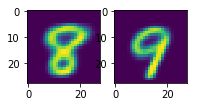

In [0]:
plt.subplot(141)
plt.imshow(result[8])
plt.subplot(142)
plt.imshow(result[9])

생성 결과, 입력한 condition에 맞게 이미지가 잘 출력된 것을 확인할 수 있다. z의 분포가 normal distribution을 따르는 Conditional VAE의 특성상, z의 좌표를 통일시키고 condition만 각각 다르게 입력해도 의미있는 이미지가 생성되는 것을 확인할 수 있다.